In [1]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 18.2 MB/s eta 0:00:00


## Import essential libraries

In [2]:
#Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load and Inspect Data

In [3]:
# Load training data
train_df = pd.read_csv("train.csv")

# Check shape and preview
print("Shape of training data:", train_df.shape)
train_df.head()


Shape of training data: (442, 3022)


,ID,05/04/2010,06/04/2010,07/04/2010,08/04/2010,09/04/2010,12/04/2010,13/04/2010,14/04/2010,15/04/2010,...,18/03/2022,21/03/2022,22/03/2022,23/03/2022,24/03/2022,25/03/2022,28/03/2022,29/03/2022,30/03/2022,31/03/2022
0,company_0,1.30,0.19,0.46,-0.23,1.20,-0.26,-0.34,1.64,1.21,...,-0.36,0.05,0.30,-3.10,0.04,0.86,0.31,0.95,0.68,-0.52
1,company_1,-0.83,0.62,-2.74,6.33,1.32,4.52,0.05,3.94,5.01,...,2.20,-3.67,3.20,-1.61,2.92,0.93,1.55,3.96,0.41,1.08
2,company_2,-0.02,0.13,-0.70,0.23,1.50,-0.23,1.35,2.26,0.37,...,-0.16,-0.74,2.52,-2.06,1.57,0.10,0.90,3.05,-1.24,-1.26
3,company_3,-1.10,-0.73,-2.98,1.98,3.00,1.01,3.60,4.30,1.05,...,2.47,-2.41,1.10,-4.08,2.09,2.02,2.74,2.33,0.80,-0.91
4,company_4,2.23,-1.45,-1.74,-1.13,0.80,1.29,0.62,3.06,-0.73,...,1.28,-1.96,0.19,-2.28,-1.13,-1.53,-0.64,2.32,-1.64,-4.58


### Data Summary

- The dataset contains daily percent stock movements for 442 companies (`company_0` to `company_441`) from 05/04/2010 to 31/03/2022.
- Each row is a company, and each column (after `ID`) is a daily percent change.My goal is to train a model that predicts the next day (01/04/2022) movement for each company as per the coursework tasks.


### Check for any missing Data

In [4]:
# Drop the 'ID' column temporarily for numeric operations
ids = train_df["ID"]
data_only = train_df.drop("ID", axis=1)

# 1. Check for missing values
missing = data_only.isnull().sum().sum()
print(f"Total missing values in dataset: {missing}")

Total missing values in dataset: 0


### Normalization

In [5]:
# Normalize each time series (z-score per row)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_only.T).T  # normalize along the time axis

# Turn it back into a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=data_only.columns)
normalized_df.insert(0, "ID", ids)

# Check result
normalized_df.head()

,ID,05/04/2010,06/04/2010,07/04/2010,08/04/2010,09/04/2010,12/04/2010,13/04/2010,14/04/2010,15/04/2010,...,18/03/2022,21/03/2022,22/03/2022,23/03/2022,24/03/2022,25/03/2022,28/03/2022,29/03/2022,30/03/2022,31/03/2022
0,company_0,0.754203,0.099256,0.258568,-0.148561,0.695199,-0.166263,-0.213466,0.954817,0.701099,...,-0.225267,0.016650,0.164161,-1.841982,0.010750,0.494585,0.170061,0.547688,0.388377,-0.319674
1,company_1,-0.259013,0.204287,-0.869290,2.028729,0.427949,1.450403,0.022162,1.265083,1.606967,...,0.709124,-1.166441,1.028641,-0.508236,0.939176,0.303337,0.501438,1.271474,0.137188,0.351265
2,company_2,-0.028168,0.057298,-0.415613,0.114275,0.837885,-0.147820,0.752419,1.270911,0.194043,...,-0.107936,-0.438403,1.419052,-1.190502,0.877769,0.040205,0.496022,1.721031,-0.723289,-0.734685
3,company_3,-0.578593,-0.392142,-1.525964,0.973482,1.487481,0.484679,1.789834,2.142578,0.504836,...,1.220404,-1.238729,0.530032,-2.080276,1.028914,0.993639,1.356462,1.149855,0.378856,-0.482848
4,company_4,1.180125,-0.805966,-0.962478,-0.633262,0.408356,0.672808,0.311210,1.628074,-0.417383,...,0.667411,-1.081212,0.079140,-1.253916,-0.633262,-0.849142,-0.368810,1.228698,-0.908509,-2.495222


### Summary of Data Cleaning & Normalization

- No missing values are found
- Each company’s time series was standardized using **z-score normalization** — to make training more stable for RNNs.



### Visualize Raw vs. Normalized Time Series

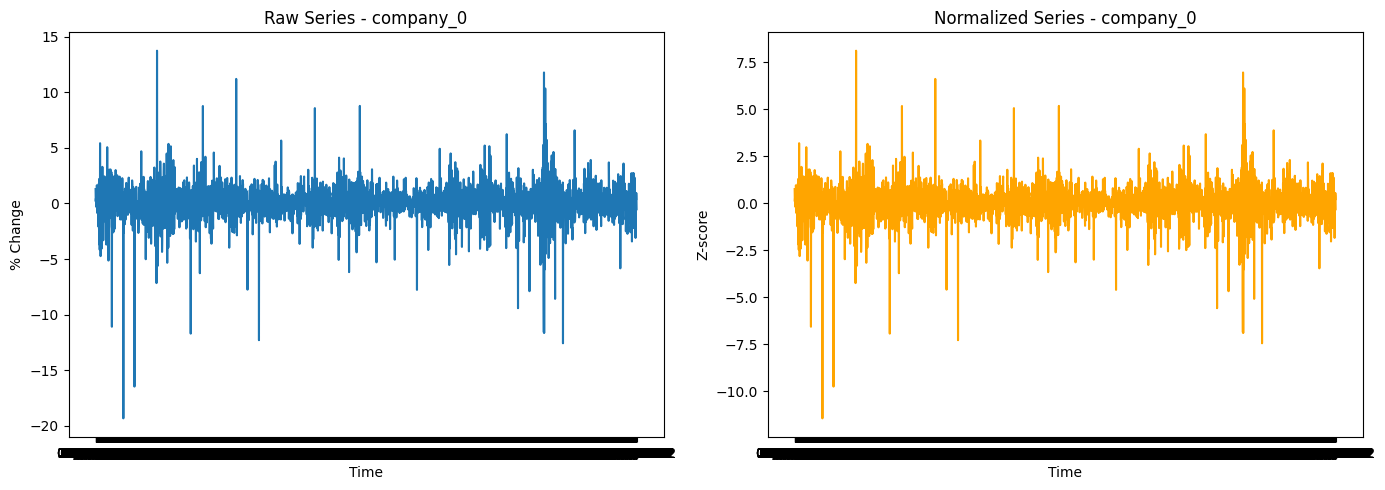

In [6]:

# Choose a company to visualize
company_index = 0  # Change this to try different companies
company_id = train_df.iloc[company_index]["ID"]

# Extract raw and normalized time series
raw_series = train_df.iloc[company_index, 1:].astype(float)
normalized_series = normalized_df.iloc[company_index, 1:]

# Extract time labels (optional, can be long)
dates = train_df.columns[1:]

# Plotting
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(dates, raw_series)
plt.title(f"Raw Series - {company_id}")
plt.xlabel("Time")
plt.ylabel("% Change")

plt.subplot(1, 2, 2)
plt.plot(dates, normalized_series, color="orange")
plt.title(f"Normalized Series - {company_id}")
plt.xlabel("Time")
plt.ylabel("Z-score")

plt.tight_layout()
plt.show()


###  Sliding Window Sequence Generation

I generate multiple `(X, y)` training pairs for each company using a **sliding window** approach:

- For each company, I extract many sequences of fixed length (`SEQ_LEN`) across the full time series.
- Each input sequence is used to predict the **next** value.
- This massively increases the training set size and helps the RNN learn more general patterns overime.

r RNNs.


In [7]:
#Create Sliding Window Dataset
SEQ_LEN = 400  # Sequence length
X = []
y = []

# Loop through each company (row)
for row in normalized_df.drop("ID", axis=1).values:
    for i in range(len(row) - SEQ_LEN):
        X.append(row[i:i+SEQ_LEN].reshape(-1, 1))  # input sequence
        y.append(row[i+SEQ_LEN])                   # target

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1158482, 400, 1)
y shape: (1158482,)


### Splitting into Training and Validation Sets

To evaluate model performance and guide hyperparameter tuning, I split the dataset into:

- **Training set (80%)**: used to train the RNN model
- **Validation set (20%)**: used to evaluate how well the model generalizes to unseen data

This will me to selecting the best model configuration with hyperparameter tuning using optuna


In [8]:
#Train / Validation Split

from sklearn.model_selection import train_test_split

# Random split (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)



Training set: (926785, 400, 1) (926785,)
Validation set: (231697, 400, 1) (231697,)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Defining the RNN Model

I define a custom PyTorch model called `StockRNN` using the `nn.Module` base class.

- It contains an LSTM layer that processes time series input of shape `(batch_size, sequence_length, input_dim)`.
- I use `batch_first=True` so the batch dimension comes first.
- The model initializes hidden and cell states with zeros.
- Only the final time step output from the LSTM is passed to a fully connected layer to produce the final prediction.

**PArams:**
- `input_dim`: Number of input features per time step
- `hidden_dim`: Number of hidden units in the LSTM
- `num_layers`: Number of LSTM layers stacked
- `output_dim`: Size of the final output (1 value per company)



In [10]:

class StockRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(StockRNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Fully connected layer to get final prediction
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_length, hidden_dim)

        # Take the output from the last time step
        out = out[:, -1, :]  # (batch_size, hidden_dim)

        # Pass through the fully connected layer
        out = self.fc(out)  # (batch_size, output_dim)

        return out




### Train the Model (with Validation)

I define a function `train_model(...)` to train the LSTM using PyTorch.

- **Input**: Training and validation datasets (`X_train`, `y_train`)
- **Model**: `StockRNN`, the custom LSTM-based regression model I defined earlier
- **Optimizer**: Adam
- **Loss Function**: Mean Squared Error (MSE)

During each epoch:
- The model is trained using mini-batches from `train_loader`
- After training, it is evaluated on the validation set
- Training and validation losses are printed to track learning


In [11]:
from torch.utils.data import TensorDataset, DataLoader

def train_model(model, X_train, y_train, X_val, y_val, device,
                epochs=20, batch_size=128, learning_rate=1e-3):

    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size)

    # Move model to device
    model = model.to(device)

    # Define optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        # Logging
        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train MSE: {train_loss/len(train_loader.dataset):.6f} - "
              f"Val MSE: {val_loss/len(val_loader.dataset):.6f}")

    print("Training complete.")
    return model




### Define Objective Function for Optuna Tuning

I define an `objective(trial)` function to enable Optuna to search for the best hyperparameters.

**Inside each trial:**
- A new model is created using sampled hyperparameters:
  - `hidden_dim`: Number of units in the LSTM layer
  - `num_layers`: Number of LSTM layers
  - `learning_rate`: For the Adam optimizer
  - `batch_size`: For mini-batch training
- The model is trained for a few epochs for speed and just to get a feel of perfomance
- The model's performance is evaluated using **validation MSE**
- The function returns the **average validation loss**, which Optuna tries to minimize

Memory cleanup is done at the end of each trial to prevent GPU out-of-memory issues that I was experiencing


In [12]:
import gc
import optuna
from torch.utils.data import DataLoader, TensorDataset

def objective(trial):
    # Suggested hyperparameters
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 2)
    learning_rate = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128])

    # Create model
    model = StockRNN(input_dim=1, hidden_dim=hidden_dim,
                     output_dim=1, num_layers=num_layers)

    # Train the model
    trained_model = train_model(
        model,
        X_train, y_train,
        X_val, y_val,
        device=device,
        epochs=5,  # Keep small for tuning
        batch_size=batch_size,
        learning_rate=learning_rate
    )

    # Validation evaluation (mini-batch)
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))
    val_loader = DataLoader(val_dataset, batch_size=512)

    trained_model.eval()
    val_loss = 0.0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = trained_model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    avg_val_loss = val_loss / len(val_dataset)

    # Clean up GPU memory between trials
    torch.cuda.empty_cache()
    gc.collect()

    return avg_val_loss


In [13]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# View best results
print("Best hyperparameters:", study.best_params)
print("Best validation MSE:", study.best_value)


[I 2025-03-27 13:05:06,688] A new study created in memory with name: no-name-9d43132a-d744-49cb-bc0d-6ceb1b29b165


Epoch [1/5] - Train MSE: 0.923463 - Val MSE: 0.887461
Epoch [2/5] - Train MSE: 0.872003 - Val MSE: 0.854156
Epoch [3/5] - Train MSE: 0.848951 - Val MSE: 0.836829
Epoch [4/5] - Train MSE: 0.830655 - Val MSE: 0.817339
Epoch [5/5] - Train MSE: 0.817935 - Val MSE: 0.808671
Training complete.


[I 2025-03-27 13:11:55,562] Trial 0 finished with value: 0.8086712594528209 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'lr': 0.0005691837499467792, 'batch_size': 128}. Best is trial 0 with value: 0.8086712594528209.


Epoch [1/5] - Train MSE: 0.929395 - Val MSE: 0.879180
Epoch [2/5] - Train MSE: 0.866347 - Val MSE: 0.850191
Epoch [3/5] - Train MSE: 0.840446 - Val MSE: 0.828066
Epoch [4/5] - Train MSE: 0.829251 - Val MSE: 0.813882
Epoch [5/5] - Train MSE: 0.819696 - Val MSE: 0.806017
Training complete.


[I 2025-03-27 13:18:48,756] Trial 1 finished with value: 0.8060174961986603 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'lr': 0.0025942600327109274, 'batch_size': 128}. Best is trial 1 with value: 0.8060174961986603.


Epoch [1/5] - Train MSE: 0.959041 - Val MSE: 0.947124
Epoch [2/5] - Train MSE: 0.936625 - Val MSE: 0.930638
Epoch [3/5] - Train MSE: 0.924606 - Val MSE: 0.922329
Epoch [4/5] - Train MSE: 0.916622 - Val MSE: 0.914418
Epoch [5/5] - Train MSE: 0.910122 - Val MSE: 0.907963
Training complete.


[I 2025-03-27 13:21:27,336] Trial 2 finished with value: 0.9079630697724386 and parameters: {'hidden_dim': 32, 'num_layers': 1, 'lr': 0.00019423536528760194, 'batch_size': 128}. Best is trial 1 with value: 0.8060174961986603.


Epoch [1/5] - Train MSE: 0.960267 - Val MSE: 0.943660
Epoch [2/5] - Train MSE: 0.929919 - Val MSE: 0.922623
Epoch [3/5] - Train MSE: 0.918482 - Val MSE: 0.914463
Epoch [4/5] - Train MSE: 0.911110 - Val MSE: 0.909534
Epoch [5/5] - Train MSE: 0.903177 - Val MSE: 0.899781
Training complete.


[I 2025-03-27 13:24:53,138] Trial 3 finished with value: 0.8997814236666586 and parameters: {'hidden_dim': 32, 'num_layers': 2, 'lr': 0.0001899213411972598, 'batch_size': 128}. Best is trial 1 with value: 0.8060174961986603.


Epoch [1/5] - Train MSE: 0.920938 - Val MSE: 0.886478
Epoch [2/5] - Train MSE: 0.870143 - Val MSE: 0.850629
Epoch [3/5] - Train MSE: 0.844444 - Val MSE: 0.830228
Epoch [4/5] - Train MSE: 0.829555 - Val MSE: 0.818026
Epoch [5/5] - Train MSE: 0.819970 - Val MSE: 0.813542
Training complete.


[I 2025-03-27 13:29:13,803] Trial 4 finished with value: 0.813542424268781 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'lr': 0.0006195860035779308, 'batch_size': 64}. Best is trial 1 with value: 0.8060174961986603.


Epoch [1/5] - Train MSE: 0.942075 - Val MSE: 0.918525
Epoch [2/5] - Train MSE: 0.910626 - Val MSE: 0.894882
Epoch [3/5] - Train MSE: 0.886510 - Val MSE: 0.873722
Epoch [4/5] - Train MSE: 0.863029 - Val MSE: 0.850761
Epoch [5/5] - Train MSE: 0.846868 - Val MSE: 0.835066
Training complete.


[I 2025-03-27 13:36:20,582] Trial 5 finished with value: 0.8350659073526677 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'lr': 0.00017235507363861166, 'batch_size': 64}. Best is trial 1 with value: 0.8060174961986603.


Epoch [1/5] - Train MSE: 0.935385 - Val MSE: 0.914276
Epoch [2/5] - Train MSE: 0.901981 - Val MSE: 0.884304
Epoch [3/5] - Train MSE: 0.873422 - Val MSE: 0.860358
Epoch [4/5] - Train MSE: 0.853390 - Val MSE: 0.840616
Epoch [5/5] - Train MSE: 0.838521 - Val MSE: 0.827294
Training complete.


[I 2025-03-27 13:40:05,101] Trial 6 finished with value: 0.8272936370270725 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'lr': 0.00041115136930903405, 'batch_size': 128}. Best is trial 1 with value: 0.8060174961986603.


Epoch [1/5] - Train MSE: 0.952155 - Val MSE: 0.938792
Epoch [2/5] - Train MSE: 0.924839 - Val MSE: 0.911992
Epoch [3/5] - Train MSE: 0.891409 - Val MSE: 0.873794
Epoch [4/5] - Train MSE: 0.875901 - Val MSE: 0.859640
Epoch [5/5] - Train MSE: 0.864077 - Val MSE: 0.861410
Training complete.


[I 2025-03-27 13:43:32,814] Trial 7 finished with value: 0.8614102345740302 and parameters: {'hidden_dim': 32, 'num_layers': 2, 'lr': 0.004474255509856189, 'batch_size': 128}. Best is trial 1 with value: 0.8060174961986603.


Epoch [1/5] - Train MSE: 0.913274 - Val MSE: 0.863883
Epoch [2/5] - Train MSE: 0.858220 - Val MSE: 0.848336
Epoch [3/5] - Train MSE: 0.841866 - Val MSE: 0.831067
Epoch [4/5] - Train MSE: 0.827162 - Val MSE: 0.821371
Epoch [5/5] - Train MSE: 0.815631 - Val MSE: 0.816003
Training complete.


[I 2025-03-27 13:48:21,262] Trial 8 finished with value: 0.8160031569034054 and parameters: {'hidden_dim': 32, 'num_layers': 2, 'lr': 0.0012286088697997907, 'batch_size': 64}. Best is trial 1 with value: 0.8060174961986603.


Epoch [1/5] - Train MSE: 0.947280 - Val MSE: 0.927867
Epoch [2/5] - Train MSE: 0.919908 - Val MSE: 0.912575
Epoch [3/5] - Train MSE: 0.906278 - Val MSE: 0.899331
Epoch [4/5] - Train MSE: 0.891627 - Val MSE: 0.881948
Epoch [5/5] - Train MSE: 0.878155 - Val MSE: 0.871690
Training complete.


[I 2025-03-27 13:52:42,299] Trial 9 finished with value: 0.8716899811921314 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'lr': 0.00015340348781251058, 'batch_size': 64}. Best is trial 1 with value: 0.8060174961986603.


Best hyperparameters: {'hidden_dim': 64, 'num_layers': 2, 'lr': 0.0025942600327109274, 'batch_size': 128}
Best validation MSE: 0.8060174961986603


### Retrain Final Model Using Best Hyperparameters

After hyperparameter tuning with Optuna, I now retrain the model using the **best combination** of parameters discovered.

- These include:
  - `hidden_dim`: LSTM size
  - `num_layers`: Number of stacked LSTM layers
  - `batch_size`: For the training bit
  - `learning_rate`: For the optimizer bit

 Train the model for **more epochs** (10) to allow it to fully learn with the optimal configuration.

This final model will be used to generate predictions for submission.


In [14]:

#Retrain Final Model with Best Params

# Pull best params from Optuna
best_params = study.best_params

# Create model with best hyperparameters
final_model = StockRNN(
    input_dim=1,
    hidden_dim=best_params["hidden_dim"],
    output_dim=1,
    num_layers=best_params["num_layers"]
)

# Retrain with more epochs for better performance
final_model = train_model(
    final_model,
    X_train, y_train,
    X_val, y_val,
    device=device,
    epochs=10,  # Increased for better learning
    batch_size=best_params["batch_size"],
    learning_rate=best_params["lr"]
)


Epoch [1/10] - Train MSE: 0.899100 - Val MSE: 0.853992
Epoch [2/10] - Train MSE: 0.853106 - Val MSE: 0.837215
Epoch [3/10] - Train MSE: 0.833493 - Val MSE: 0.823572
Epoch [4/10] - Train MSE: 0.818465 - Val MSE: 0.810713
Epoch [5/10] - Train MSE: 0.814690 - Val MSE: 0.803625
Epoch [6/10] - Train MSE: 0.809980 - Val MSE: 0.812131
Epoch [7/10] - Train MSE: 0.810147 - Val MSE: 0.816297
Epoch [8/10] - Train MSE: 0.812876 - Val MSE: 0.807438
Epoch [9/10] - Train MSE: 0.858570 - Val MSE: 0.974379
Epoch [10/10] - Train MSE: 0.968622 - Val MSE: 0.971226
Training complete.


### Generate Predictions and Create Submission File

Using the trained model, I  predict for each of the 442 companies for the date **01/04/2022**:

- For each company,  extract the final `SEQ_LEN` days of normalized data
- The model predicts the next day's movement
- Predictions are saved into the `sample_submission.csv` template

My final output file `my_final_submission.csv` has been submitted on kaggle

In [15]:

# Predict 01/04/2022 & Save File

def predict_next_day(model, normalized_df, seq_len, device):
    model.eval()
    model = model.to(device)

    predictions = []

    with torch.no_grad():
        for row in normalized_df.drop("ID", axis=1).values:
            # Get the last SEQ_LEN values
            input_seq = row[-seq_len:].reshape(1, seq_len, 1)
            input_tensor = torch.tensor(input_seq, dtype=torch.float32).to(device)

            # Predict
            output = model(input_tensor)
            pred = output.item()
            predictions.append(pred)

    return predictions

# Run prediction
final_predictions = predict_next_day(final_model, normalized_df, SEQ_LEN, device)

# Load sample submission
submission_df = pd.read_csv("sample_submission.csv")

# Fill in predicted values
submission_df["value"] = final_predictions

# Save to CSV
submission_df.to_csv("my_final_submission.csv", index=False)
print("Submission saved as 'my_final_submission.csv'")


Submission saved as 'my_final_submission.csv'


### Interpret Model Predictions with Captum (Integrated Gradients)

I use Captum's Integrated Gradients to visualize which time steps in the input sequence had the most influence on the model's prediction.

Steps:
1. Choose a single sample from the training set
2. Use Captum to compute attribution scores for each time step
3. Visualize the importance of each day in the sequence

This helps me understand how the LSTM uses past time steps when predicting the stock movement on the next day.


In [16]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 852.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 508.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Single Company

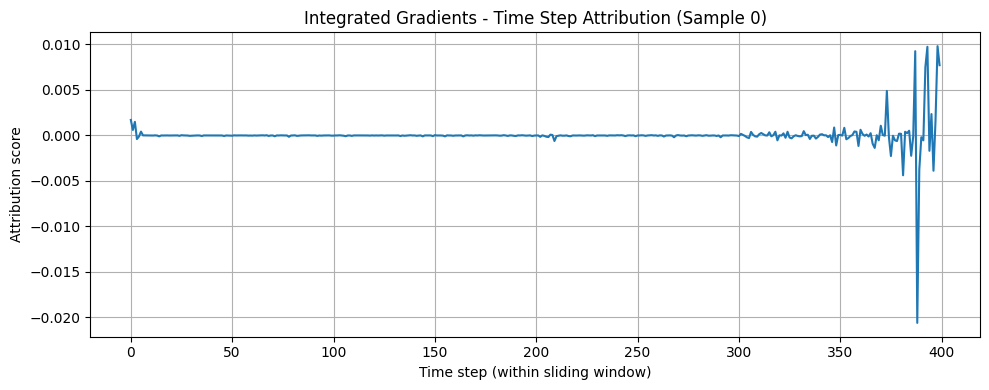

In [17]:
# Captum: Interpret model with Integrated Gradients (LSTM-safe)
from captum.attr import IntegratedGradients
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Choose a sample input from X_train
sample_idx = 0  # Change this to explore other samples
input_tensor = torch.tensor(X_train[sample_idx:sample_idx+1], dtype=torch.float32).to(device)
input_tensor.requires_grad = True  # Enable gradient tracking

# Set model to training mode (required for LSTM backward on GPU)
final_model.train().to(device)

#Create Captum interpreter
ig = IntegratedGradients(final_model)

# Compute attributions
baseline = torch.zeros_like(input_tensor).to(device)

attributions, delta = ig.attribute(
    inputs=input_tensor,
    baselines=baseline,
    target=0,
    return_convergence_delta=True
)

# Visualize attribution scores
attr_np = attributions.squeeze().cpu().detach().numpy()

plt.figure(figsize=(10, 4))
plt.title(f"Integrated Gradients - Time Step Attribution (Sample {sample_idx})")
plt.xlabel("Time step (within sliding window)")
plt.ylabel("Attribution score")
plt.plot(range(len(attr_np)), attr_np, label="Attribution")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpret Multiple Company Predictions with Captum

To better understand how our LSTM model makes predictions across different companies, I use **Captum’s** on multiple companies from the training data.

In this section:

- I loop through multiple companies from the training set (`X_train`)
- For each company, I extract the input sequence
- Calculate **attribution scores** for each time step using Captum
- Visualize both:
  - The **normalized input time series** (daily percent movements)
  - The **attribution scores** (importance of each day in the prediction)

This helps me see whether the model consistently focuses on recent days across different companies, or if its behavior varies from one company to another.


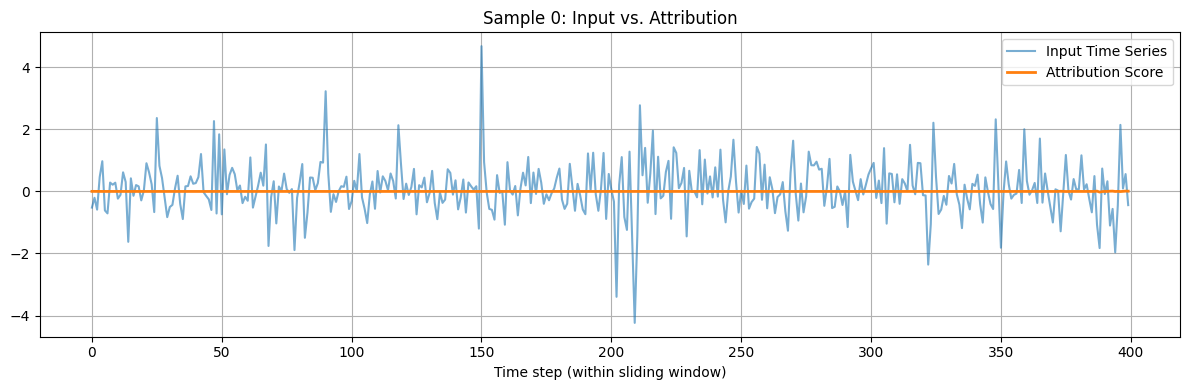

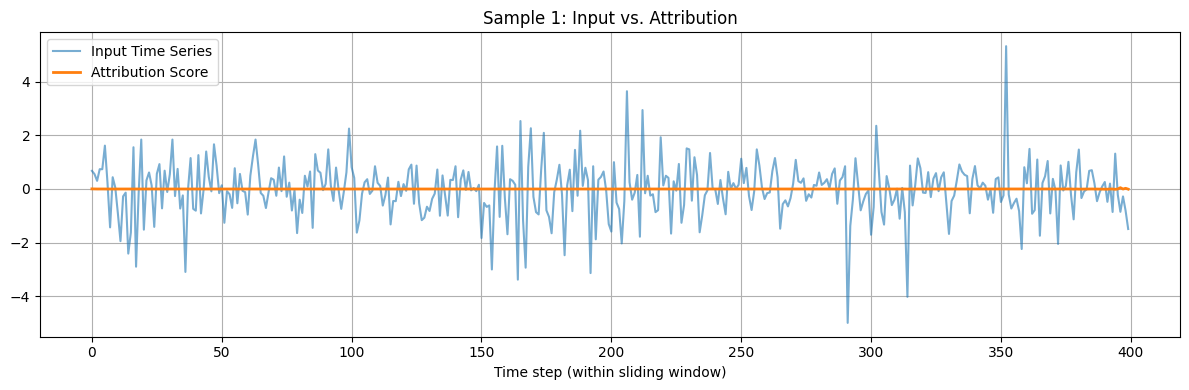

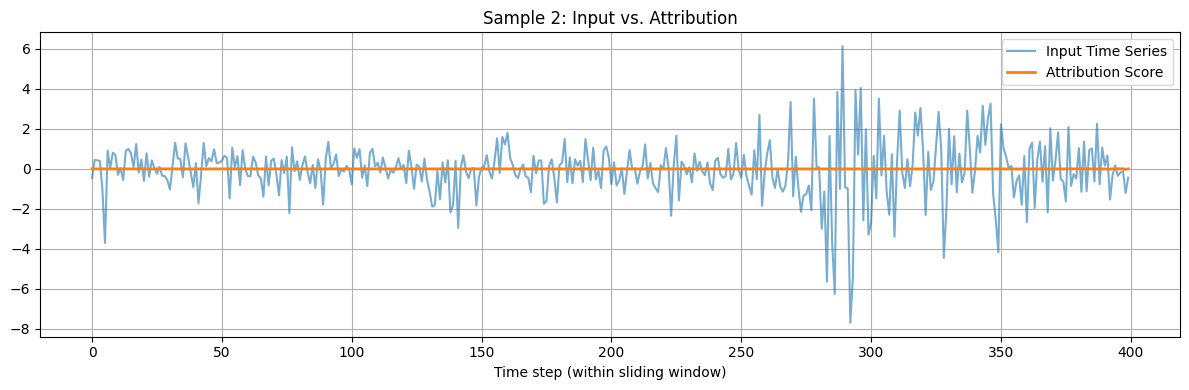

In [18]:

# Set model to training mode for LSTM + CUDA compatibility
final_model.train().to(device)

# Captum wrapper
ig = IntegratedGradients(final_model)

# Number of samples to visualize
n_samples = 3  # Change this to analyze more companies

for sample_idx in range(n_samples):
    # Input sequence and baseline
    input_tensor = torch.tensor(X_train[sample_idx:sample_idx+1], dtype=torch.float32).to(device)
    input_tensor.requires_grad = True
    baseline = torch.zeros_like(input_tensor).to(device)

    # Get attributions
    attributions, _ = ig.attribute(
        inputs=input_tensor,
        baselines=baseline,
        target=0,
        return_convergence_delta=True
    )
    attr_np = attributions.squeeze().cpu().detach().numpy()
    input_np = input_tensor.squeeze().cpu().detach().numpy()

    # Plot side-by-side
    plt.figure(figsize=(12, 4))
    plt.title(f"Sample {sample_idx}: Input vs. Attribution")
    plt.plot(input_np, label="Input Time Series", alpha=0.6)
    plt.plot(attr_np, label="Attribution Score", linewidth=2)
    plt.xlabel("Time step (within sliding window)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Captum Interpretation

I used **Integrated Gradients** from Captum to identify which time steps in each input sequence had the most influence on the model's prediction.

**Observations:**
- In both samples, the model assigns **very low attribution** to most time steps.
- The **input sequences are highly volatile**, but the **attribution scores remain near zero**.
- This suggests the relies only on a few recent steps (but attributing almost nothing strongly).
